In [46]:
!pip install scikit-learn xgboost imbalanced-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind, chi2_contingency, f_oneway
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from statsmodels.formula.api import ols


df = pd.read_csv('/kaggle/input/bangladeshi-university-students-mental-health/Raw Data.csv')

In [47]:
# Set display option to show all columns
pd.set_option('display.max_columns', None)

df.head()

,1. Age,2. Gender,3. University,4. Department,5. Academic Year,6. Current CGPA,7. Did you receive a waiver or scholarship at your university?,"1. In a semester, how often you felt nervous, anxious or on edge due to academic pressure?","2. In a semester, how often have you been unable to stop worrying about your academic affairs?","3. In a semester, how often have you had trouble relaxing due to academic pressure?","4. In a semester, how often have you been easily annoyed or irritated because of academic pressure?","5. In a semester, how often have you worried too much about academic affairs?","6. In a semester, how often have you been so restless due to academic pressure that it is hard to sit still?","7. In a semester, how often have you felt afraid, as if something awful might happen?",Anxiety Value,Anxiety Label,"1. In a semester, how often have you felt upset due to something that happened in your academic affairs?","2. In a semester, how often you felt as if you were unable to control important things in your academic affairs?","3. In a semester, how often you felt nervous and stressed because of academic pressure?","4. In a semester, how often you felt as if you could not cope with all the mandatory academic activities? (e.g, assignments, quiz, exams)","5. In a semester, how often you felt confident about your ability to handle your academic / university problems?","6. In a semester, how often you felt as if things in your academic life is going on your way?","7. In a semester, how often are you able to control irritations in your academic / university affairs?","8. In a semester, how often you felt as if your academic performance was on top?","9. In a semester, how often you got angered due to bad performance or low grades that is beyond your control?","10. In a semester, how often you felt as if academic difficulties are piling up so high that you could not overcome them?",Stress Value,Stress Label,"1. In a semester, how often have you had little interest or pleasure in doing things?","2. In a semester, how often have you been feeling down, depressed or hopeless?","3. In a semester, how often have you had trouble falling or staying asleep, or sleeping too much?","4. In a semester, how often have you been feeling tired or having little energy?","5. In a semester, how often have you had poor appetite or overeating?","6. In a semester, how often have you been feeling bad about yourself - or that you are a failure or have let yourself or your family down?","7. In a semester, how often have you been having trouble concentrating on things, such as reading the books or watching television?","8. In a semester, how often have you moved or spoke too slowly for other people to notice? Or you've been moving a lot more than usual because you've been restless?","9. In a semester, how often have you had thoughts that you would be better off dead, or of hurting yourself?",Depression Value,Depression Label
0,18-22,Female,"Independent University, Bangladesh (IUB)",Engineering - CS / CSE / CSC / Similar to CS,Fourth Year or Equivalent,2.50 - 2.99,No,1,1,1,2,2,2,1,10,Moderate Anxiety,2,2,3,2,2,2,2,2,2,2,21,Moderate Stress,1,2,1,1,2,1,1,1,1,11,Moderate Depression
1,18-22,Male,"Independent University, Bangladesh (IUB)",Engineering - CS / CSE / CSC / Similar to CS,First Year or Equivalent,3.80 - 4.00,No,2,2,1,1,1,1,1,9,Mild Anxiety,2,2,2,2,2,2,2,1,1,2,18,Moderate Stress,1,1,1,1,1,1,1,1,1,9,Mild Depression
2,18-22,Male,"Independent University, Bangladesh (IUB)",Engineering - CS / CSE / CSC / Similar to CS,First Year or Equivalent,3.00 - 3.39,No,2,1,1,0,2,2,2,10,Moderate Anxiety,3,2,2,3,3,2,3,2,2,1,23,Moderate Stress,2,0,2,3,2,2,2,2,1,16,Moderately Severe Depression
3,18-22,Male,"Independent University, Bangladesh (IUB)",Engineering - CS / CSE / CSC / Similar to CS,First Year or Equivalent,3.40 - 3.79,No,2,1,1,1,1,1,1,8,Mild Anxiety,2,2,2,2,2,2,2,2,2,2,20,Moderate Stress,1,1,1,1,1,1,1,1,1,9,Mild Depression
4,18-22,Male,"Independent University,

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977 entries, 0 to 1976
Data columns (total 39 columns):
 #   Column                                                                                                                                                                 Non-Null Count  Dtype 
---  ------                                                                                                                                                                 --------------  ----- 
 0   1. Age                                                                                                                                                                 1977 non-null   object
 1   2. Gender                                                                                                                                                              1977 non-null   object
 2   3. University                                                                                               

In [49]:
# One-hot encoding for Gender with integer output
gender_dummies = pd.get_dummies(df['2. Gender'], prefix='Gender')
gender_dummies = gender_dummies.astype(int)

# Drop the original Gender column and concatenate the new one-hot encoded columns
df = df.drop('2. Gender', axis=1)
df = pd.concat([df, gender_dummies], axis=1)

# One-hot encoding for university with integer output
gender_dummies = pd.get_dummies(df['3. University'], prefix='University')
gender_dummies = gender_dummies.astype(int)

# Drop the original University column and concatenate the new one-hot encoded columns
df = df.drop('3. University', axis=1)
df = pd.concat([df, gender_dummies], axis=1)

# One-hot encoding for Department with integer output
gender_dummies = pd.get_dummies(df['4. Department'], prefix='Department')
gender_dummies = gender_dummies.astype(int)

# Drop the original Department column and concatenate the new one-hot encoded columns
df = df.drop('4. Department', axis=1)
df = pd.concat([df, gender_dummies], axis=1)

# One-hot encoding for Waiver with integer output
gender_dummies = pd.get_dummies(df['7. Did you receive a waiver or scholarship at your university?'], prefix='Waiver')
gender_dummies = gender_dummies.astype(int)

# Drop the original Waiver column and concatenate the new one-hot encoded columns
df = df.drop('7. Did you receive a waiver or scholarship at your university?', axis=1)
df = pd.concat([df, gender_dummies], axis=1)

# Label encoding for Age
age_mapping = {
    'Below 18': 0,
    '18-22': 1,
    '23-26': 2,
    '27-30': 3,
    'Above 30': 4
}
df['1. Age'] = df['1. Age'].map(age_mapping)

# Label encoding for Academic Year and Current CGPA
academic_year_mapping = {
    'First Year or Equivalent': 1,
    'Second Year or Equivalent': 2,
    'Third Year or Equivalent': 3,
    'Fourth Year or Equivalent': 4,
    'Other': 5
}
df['5. Academic Year'] = df['5. Academic Year'].map(academic_year_mapping)

cgpa_mapping = {
    'Below 2.50': 0,
    '2.50 - 2.99': 1,
    '3.00 - 3.39': 2,
    '3.40 - 3.79': 3,
    '3.80 - 4.00': 4,
    'Other': 5
}
df['6. Current CGPA'] = df['6. Current CGPA'].map(cgpa_mapping)

# Define the order for the labels
anxiety_mapping = {
    'Minimal Anxiety': 0,
    'Mild Anxiety': 1,
    'Moderate Anxiety': 2,
    'Severe Anxiety': 3
}
stress_mapping = {
    'Low Stress': 0,
    'Moderate Stress': 1,
    'High Perceived Stress': 2
}
depression_mapping = {
    'No Depression': 0,
    'Minimal Depression': 1,
    'Mild Depression': 2,
    'Moderate Depression': 3,
    'Moderately Severe Depression': 4,
    'Severe Depression': 5
}

# Apply label encoding
df['Anxiety Label'] = df['Anxiety Label'].map(anxiety_mapping)
df['Stress Label'] = df['Stress Label'].map(stress_mapping)
df['Depression Label'] = df['Depression Label'].map(depression_mapping)

In [50]:
# Drop specific columns
columns_to_drop = ['1. Age', '6. Current CGPA', '1. In a semester, how often you felt nervous, anxious or on edge due to academic pressure? ',
       '2. In a semester, how often have you been unable to stop worrying about your academic affairs? ',
       '3. In a semester, how often have you had trouble relaxing due to academic pressure? ',
       '4. In a semester, how often have you been easily annoyed or irritated because of academic pressure?',
       '5. In a semester, how often have you worried too much about academic affairs? ',
       '6. In a semester, how often have you been so restless due to academic pressure that it is hard to sit still?',
       '7. In a semester, how often have you felt afraid, as if something awful might happen?',
       '1. In a semester, how often have you felt upset due to something that happened in your academic affairs? ',
       '2. In a semester, how often you felt as if you were unable to control important things in your academic affairs?',
       '3. In a semester, how often you felt nervous and stressed because of academic pressure? ',
       '4. In a semester, how often you felt as if you could not cope with all the mandatory academic activities? (e.g, assignments, quiz, exams) ',
       '5. In a semester, how often you felt confident about your ability to handle your academic / university problems?',
       '6. In a semester, how often you felt as if things in your academic life is going on your way? ',
       '7. In a semester, how often are you able to control irritations in your academic / university affairs? ',
       '8. In a semester, how often you felt as if your academic performance was on top?',
       '9. In a semester, how often you got angered due to bad performance or low grades that is beyond your control? ',
       '10. In a semester, how often you felt as if academic difficulties are piling up so high that you could not overcome them? ',
       '1. In a semester, how often have you had little interest or pleasure in doing things?',
       '2. In a semester, how often have you been feeling down, depressed or hopeless?',
       '3. In a semester, how often have you had trouble falling or staying asleep, or sleeping too much? ',
       '4. In a semester, how often have you been feeling tired or having little energy? ',
       '5. In a semester, how often have you had poor appetite or overeating? ',
       '6. In a semester, how often have you been feeling bad about yourself - or that you are a failure or have let yourself or your family down? ',
       '7. In a semester, how often have you been having trouble concentrating on things, such as reading the books or watching television? ',
       "8. In a semester, how often have you moved or spoke too slowly for other people to notice? Or you've been moving a lot more than usual because you've been restless? ",
       '9. In a semester, how often have you had thoughts that you would be better off dead, or of hurting yourself? ',
       'University_American International University Bangladesh (AIUB)',
       'University_BRAC University',
       'University_Bangladesh Agricultural University (BAU)',
       'University_Bangladesh University of Engineering and Technology (BUET)',
       'University_Daffodil University', 'University_Dhaka University (DU)',
       'University_Dhaka University of Engineering and Technology (DUET)',
       'University_East West University (EWU)',
       'University_Independent University, Bangladesh (IUB)',
       'University_Islamic University of Technology (IUT)',
       'University_North South University (NSU)',
       'University_Patuakhali Science and Technology University',
       'University_Rajshahi University (RU)',
       'University_Rajshahi University of Engineering and Technology (RUET)',
       'University_United International University (UIU)',
       'Department_Biological Sciences',
       'Department_Business and Entrepreneurship Studies',
       'Department_Engineering - CS / CSE / CSC / Similar to CS',
       'Department_Engineering - Civil Engineering / Similar to CE',
       'Department_Engineering - EEE/ ECE / Similar to EEE',
       'Department_Engineering - Mechanical Engineering / Similar to ME',
       'Department_Engineering - Other',
       'Department_Environmental and Life Sciences',
       'Department_Law and Human Rights',
       'Department_Liberal Arts and Social Sciences', 'Department_Other',
       'Department_Pharmacy and Public Health', 'Waiver_No', 'Waiver_Yes', 'Gender_Female',
       'Gender_Male', 'Gender_Prefer not to say', '5. Academic Year']
df = df.drop(columns_to_drop, axis=1)

In [51]:
df.head()

,Anxiety Value,Anxiety Label,Stress Value,Stress Label,Depression Value,Depression Label
0,10,2,21,1,11,3
1,9,1,18,1,9,2
2,10,2,23,1,16,4
3,8,1,20,1,9,2
4,7,1,20,1,9,2


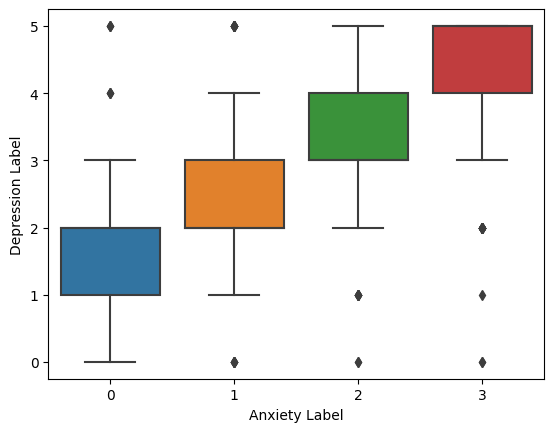

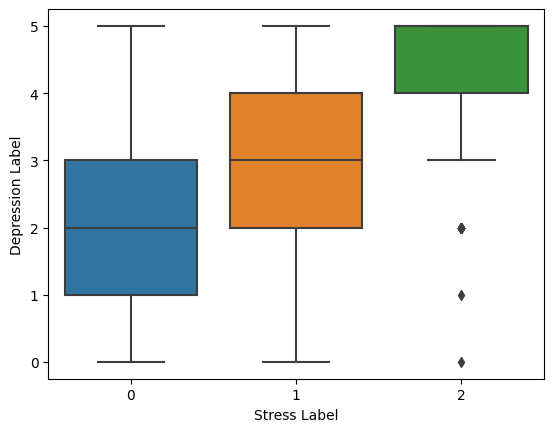

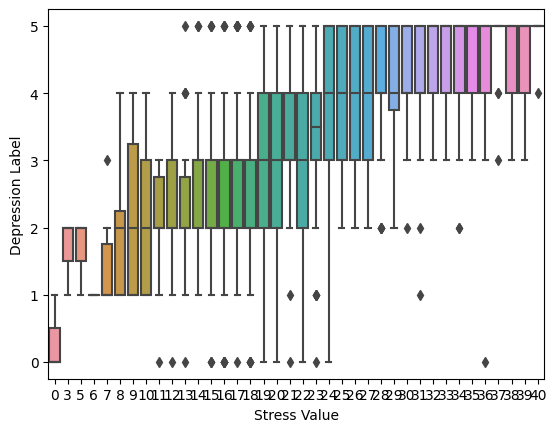

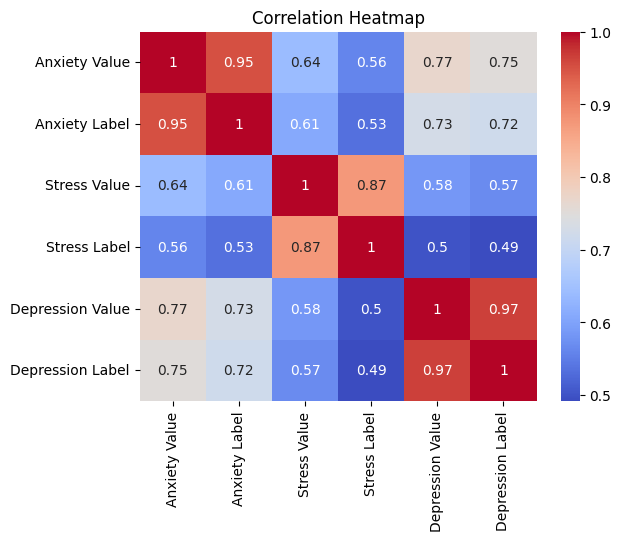

In [52]:
# Boxplot for Anxiety, Stress, and Depression Labels
label_columns = ['Anxiety Label', 'Stress Label', 'Stress Value']
for column in label_columns:
    sns.boxplot(x=column, y='Depression Label', data=df)
    plt.show()

# Correlation heatmap for numerical variables
numerical_columns = ['Anxiety Value', 'Anxiety Label', 'Stress Value',
                    'Stress Label', 'Depression Value', 'Depression Label']
correlation_matrix = df[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [53]:
# Fit the Isolation Forest model
isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(df)

outlier_pred

array([ 1,  1,  1, ..., -1,  1, -1])

In [54]:
# Add predictions to the DataFrame
df['outlier'] = outlier_pred

# Filter out the outliers
df_clean = df[df['outlier'] == 1].drop(columns=['outlier'])

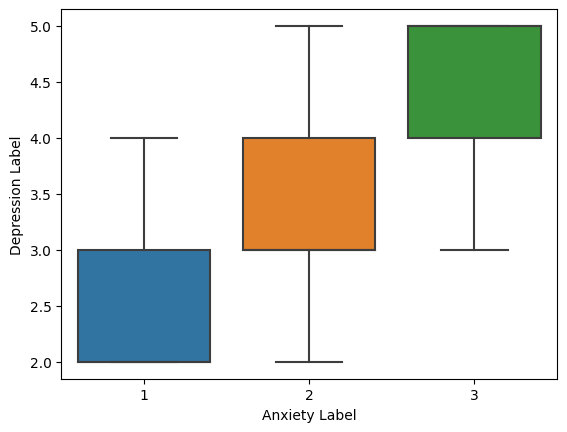

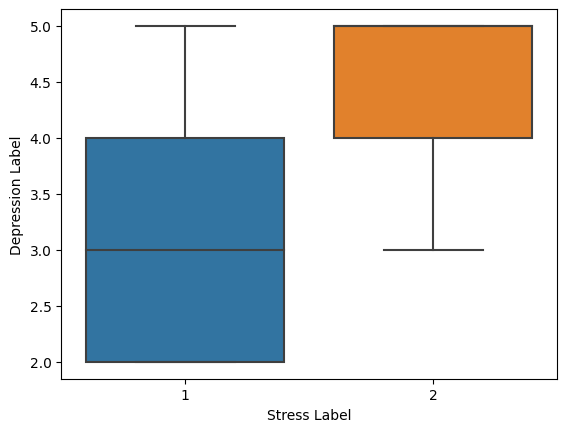

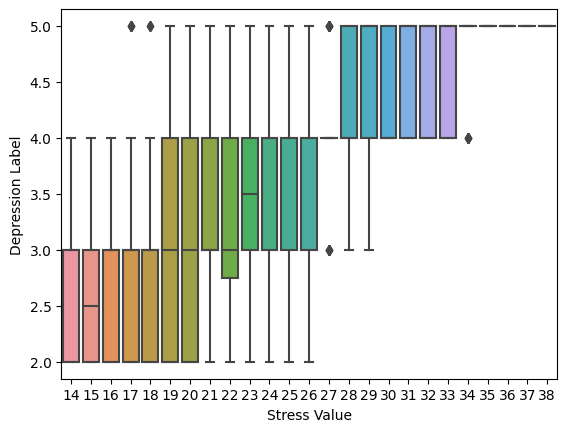

In [55]:
# Boxplot for Anxiety, Stress, and Depression Labels
label_columns = ['Anxiety Label', 'Stress Label', 'Stress Value']
for column in label_columns:
    sns.boxplot(x=column, y='Depression Label', data=df_clean)
    plt.show()


In [68]:
# T-tests
t_test_depression = ttest_ind(df_clean[df_clean['Depression Label'] == 2]['Anxiety Value'], 
                              df_clean[df_clean['Depression Label'] == 3]['Anxiety Value'], equal_var=False)

print("T-test Results:")
print("Depression:", t_test_depression)

def print_t_test_result(test_name, test_result):
    if test_result.pvalue < 0.05:
        print(f"{test_name}: Reject the null hypothesis (p-value = {test_result.pvalue})")
    else:
        print(f"{test_name}: Fail to reject the null hypothesis (p-value = {test_result.pvalue})")

print_t_test_result("Depression", t_test_depression)


T-test Results:
Depression: TtestResult(statistic=-9.760269839136674, pvalue=4.8581207688877196e-21, df=624.4233192852093)
Depression: Reject the null hypothesis (p-value = 4.8581207688877196e-21)


In [69]:
# Chi-square tests
chi2_stress_depression = chi2_contingency(pd.crosstab(df_clean['Stress Label'], df_clean['Depression Label']))

print("Chi-square Test Results:")
print("Stress-Depression:", chi2_stress_depression)

def print_chi2_test_result(test_name, test_result):
    if test_result[1] < 0.05:
        print(f"{test_name}: Reject the null hypothesis (p-value = {test_result[1]})")
    else:
        print(f"{test_name}: Fail to reject the null hypothesis (p-value = {test_result[1]})")

print_chi2_test_result("Stress-Depression", chi2_stress_depression)


Chi-square Test Results:
Stress-Depression: Chi2ContingencyResult(statistic=429.5937789823007, pvalue=8.59750927746276e-93, dof=3, expected_freq=array([[229.29134467, 258.62828439, 310.35394127, 200.72642968],
       [ 67.70865533,  76.37171561,  91.64605873,  59.27357032]]))
Stress-Depression: Reject the null hypothesis (p-value = 8.59750927746276e-93)


In [71]:
# Two-way ANOVA
model = ols('Q("Anxiety Value") ~ C(Q("Anxiety Label")) * C(Q("Depression Label"))', data=df_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("Two-way ANOVA Results:")
print(anova_table)

def print_anova_result(anova_table):
    for index, row in anova_table.iterrows():
        if row['PR(>F)'] < 0.05:
            print(f"{index}: Reject the null hypothesis (p-value = {row['PR(>F)']})")
        else:
            print(f"{index}: Fail to reject the null hypothesis (p-value = {row['PR(>F)']})")

print_anova_result(anova_table)


Two-way ANOVA Results:
                                                      sum_sq      df  \
C(Q("Anxiety Label"))                              80.972761     2.0   
C(Q("Depression Label"))                         2273.929763     3.0   
C(Q("Anxiety Label")):C(Q("Depression Label"))  18210.178825     6.0   
Residual                                         2631.948588  1284.0   

                                                          F         PR(>F)  
C(Q("Anxiety Label"))                             19.751340   3.559651e-09  
C(Q("Depression Label"))                         369.779996  4.653920e-173  
C(Q("Anxiety Label")):C(Q("Depression Label"))  1480.643766   0.000000e+00  
Residual                                                NaN            NaN  
C(Q("Anxiety Label")): Reject the null hypothesis (p-value = 3.559650691155783e-09)
C(Q("Depression Label")): Reject the null hypothesis (p-value = 4.6539199732304466e-173)
C(Q("Anxiety Label")):C(Q("Depression Label")): Reject the

In [72]:
# Regression analysis
X = df_clean[['Anxiety Value']]
y = df_clean['Depression Label']
X = sm.add_constant(X)
model_reg = sm.OLS(y, X).fit()

print("Regression Analysis Results:")
print(model_reg.summary())

def print_regression_result(model_summary):
    for i, row in enumerate(model_summary.tables[1].data[1:]):
        p_value = float(row[-1])
        if p_value < 0.05:
            print(f"{row[0]}: Reject the null hypothesis (p-value = {p_value})")
        else:
            print(f"{row[0]}: Fail to reject the null hypothesis (p-value = {p_value})")

print_regression_result(model_reg.summary())


Regression Analysis Results:
                            OLS Regression Results                            
Dep. Variable:       Depression Label   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     1812.
Date:                Sun, 26 May 2024   Prob (F-statistic):          3.79e-248
Time:                        15:01:41   Log-Likelihood:                -1336.9
No. Observations:                1294   AIC:                             2678.
Df Residuals:                    1292   BIC:                             2688.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            

In [76]:
# Define features and target
y = df['Depression Label']
X = df.drop(columns=['Depression Label'])

# Map labels to start from 0
y_mapped = y - y.min()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Standardize the data for models that need it
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression with increased iterations
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

# Support Vector Machine (SVM)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

# XGBoost with early stopping and proper configuration for multi-class classification
xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='mlogloss', 
    n_estimators=500, 
    learning_rate=0.01,
    max_depth=4,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=1,
    reg_lambda=1,
    early_stopping_rounds=10
)

# Perform stratified k-fold cross-validation with early stopping
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, val_idx in cv.split(X_train_scaled, y_train):
    X_train_cv, X_val_cv = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    xgb_model.fit(X_train_cv, y_train_cv, eval_set=[(X_val_cv, y_val_cv)], verbose=False)
    y_pred_cv = xgb_model.predict(X_val_cv)
    cv_scores.append(accuracy_score(y_val_cv, y_pred_cv))


# Fit the XGBoost model with early stopping on the full training set
xgb_model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)
y_pred_xgb = xgb_model.predict(X_test_scaled)



# Evaluation function to print the metrics
def evaluate_model(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"Model: {model_name}")
    print(confusion_matrix(y_test, y_pred))
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}\n")

# Evaluating all models
evaluate_model(y_test, y_pred_lr, 'Logistic Regression')
evaluate_model(y_test, y_pred_rf, 'Random Forest')
evaluate_model(y_test, y_pred_svm, 'SVM')
evaluate_model(y_test, y_pred_xgb, 'XGBoost')


Model: Logistic Regression
[[  3   6   0   0   0   0]
 [  1  13   2   0   0   0]
 [  0   2  67   2   0   0]
 [  0   0  10  85   0   0]
 [  0   0   0   0 112   0]
 [  0   0   0   0   0  93]]
Logistic Regression Performance:
Accuracy: 0.9419
Precision: 0.8657
Recall: 0.8307
F1-Score: 0.8319

Model: Random Forest
[[  8   0   1   0   0   0]
 [  0  16   0   0   0   0]
 [  0   0  71   0   0   0]
 [  0   0   0  95   0   0]
 [  0   0   0   0 112   0]
 [  0   0   0   0   0  93]]
Random Forest Performance:
Accuracy: 0.9975
Precision: 0.9977
Recall: 0.9815
F1-Score: 0.9890

Model: SVM
[[  7   2   0   0   0   0]
 [  0  16   0   0   0   0]
 [  0   3  68   0   0   0]
 [  0   0   0  95   0   0]
 [  0   0   0   0 111   1]
 [  0   0   0   0   0  93]]
SVM Performance:
Accuracy: 0.9848
Precision: 0.9585
Recall: 0.9544
F1-Score: 0.9514

Model: XGBoost
[[  9   0   0   0   0   0]
 [  0  16   0   0   0   0]
 [  0   0  71   0   0   0]
 [  0   0   0  95   0   0]
 [  0   0   0   0 112   0]
 [  0   0   0   0   0

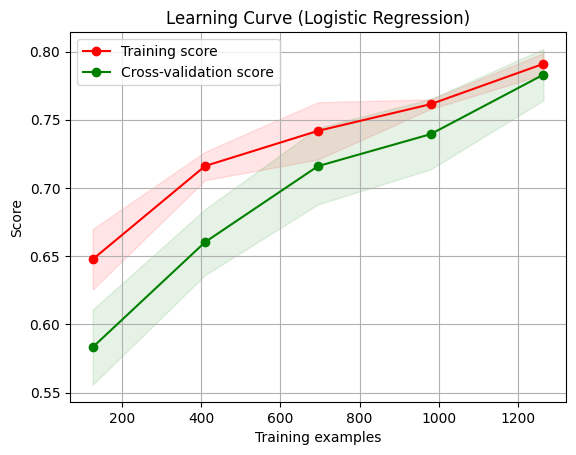

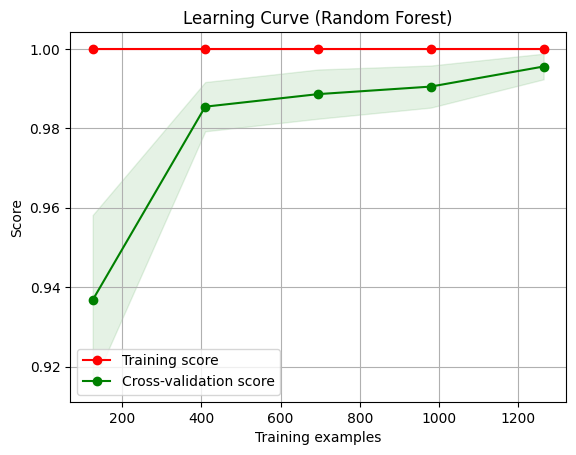

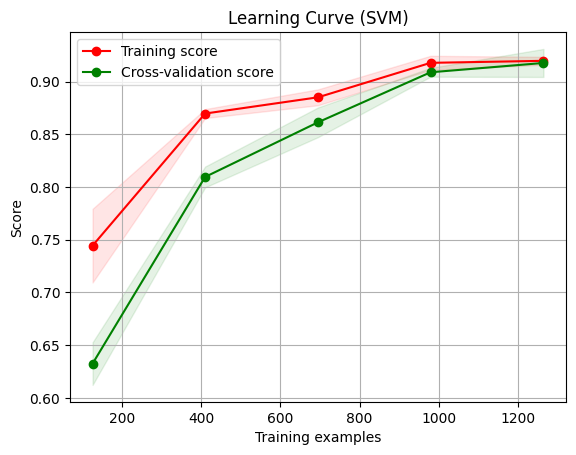

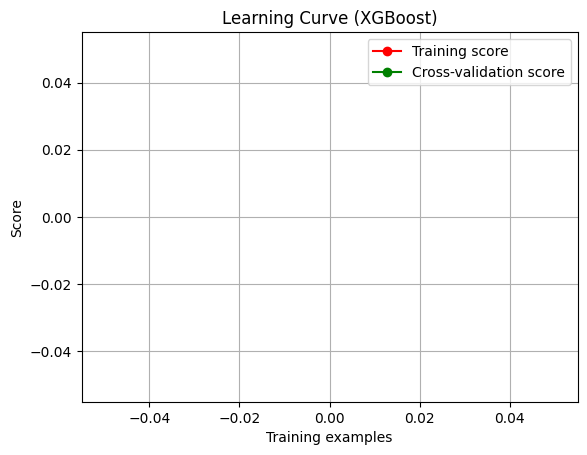

In [62]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves for each model
plot_learning_curve(lr_model, "Learning Curve (Logistic Regression)", X_train_scaled, y_train)
plot_learning_curve(rf_model, "Learning Curve (Random Forest)", X_train, y_train)
plot_learning_curve(svm_model, "Learning Curve (SVM)", X_train_scaled, y_train)
plot_learning_curve(xgb_model, "Learning Curve (XGBoost)", X_train, y_train)

plt.show()


In [64]:
!pip install shap

TypeError: list indices must be integers or slices, not tuple

In [67]:
import shap

# Ensure the SVM model is trained with probability=True
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_scaled, y_train)

# SHAP analysis for SVM
explainer_svm = shap.KernelExplainer(svm_model.predict_proba, X_train_scaled)
shap_values_svm = explainer_svm.shap_values(X_train_scaled)

# Visualize the first prediction's explanation for SVM
shap.initjs()
shap.force_plot(explainer_svm.expected_value[0], shap_values_svm[0][0], X_train.iloc[0,:])



  0%|          | 0/1581 [00:00<?, ?it/s]

  0%|          | 0/1581 [00:00<?, ?it/s]

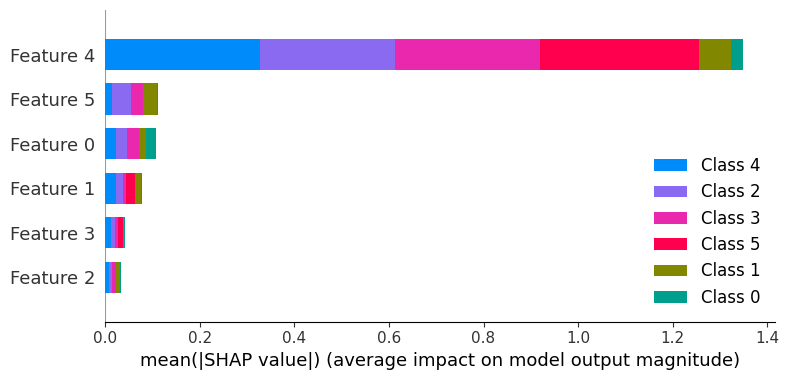

AssertionError: Only plot_type = 'bar' is supported for multi-output explanations!

In [73]:
# Ensure the SVM model is trained with probability=True
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_scaled, y_train)

# SHAP analysis for SVM
explainer_svm = shap.KernelExplainer(svm_model.predict_proba, X_train_scaled)
shap_values_svm = explainer_svm.shap_values(X_train_scaled)

# Generate SHAP summary plot
shap.summary_plot(shap_values_svm, X_train_scaled, plot_type="bar")

# You can also create a detailed SHAP summary plot (beeswarm plot) to see the distribution
shap.summary_plot(shap_values_svm, X_train_scaled, plot_type='dot')